In [1]:
pip install fastai

Note: you may need to restart the kernel to use updated packages.


In [2]:
from fastai.vision.all import *
from fastai import *
from pathlib import Path
import pandas as pd

In [3]:
torch.cuda.set_device(7)

In [4]:
import zipfile

# Specify the path to the zip file
zip_file_path = '/raid10/active_users/groupA/ml/data.zip'

# Specify the directory where you want to extract the contents
extracted_dir = '/raid10/active_users/groupA/ml'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extracted_dir)

In [5]:
train_data = Path('/raid10/active_users/groupA/ml/train')
test_data = Path('/raid10/active_users/groupA/ml/test')

In [6]:
train_fns = get_image_files(train_data)
train_fns

test_fns = get_image_files(test_data)
test_fns

(#794) [Path('/raid10/active_users/groupA/ml/test/d7017f701.png'),Path('/raid10/active_users/groupA/ml/test/6680836dd.png'),Path('/raid10/active_users/groupA/ml/test/a0b393945.png'),Path('/raid10/active_users/groupA/ml/test/e783f5a4f.png'),Path('/raid10/active_users/groupA/ml/test/d93c7ab6d.png'),Path('/raid10/active_users/groupA/ml/test/df7cb5f87.png'),Path('/raid10/active_users/groupA/ml/test/24c94a6ca.png'),Path('/raid10/active_users/groupA/ml/test/444473900.png'),Path('/raid10/active_users/groupA/ml/test/9baf94467.png'),Path('/raid10/active_users/groupA/ml/test/3f92d8039.png')...]

/raid10/active_users/groupA/miniconda/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


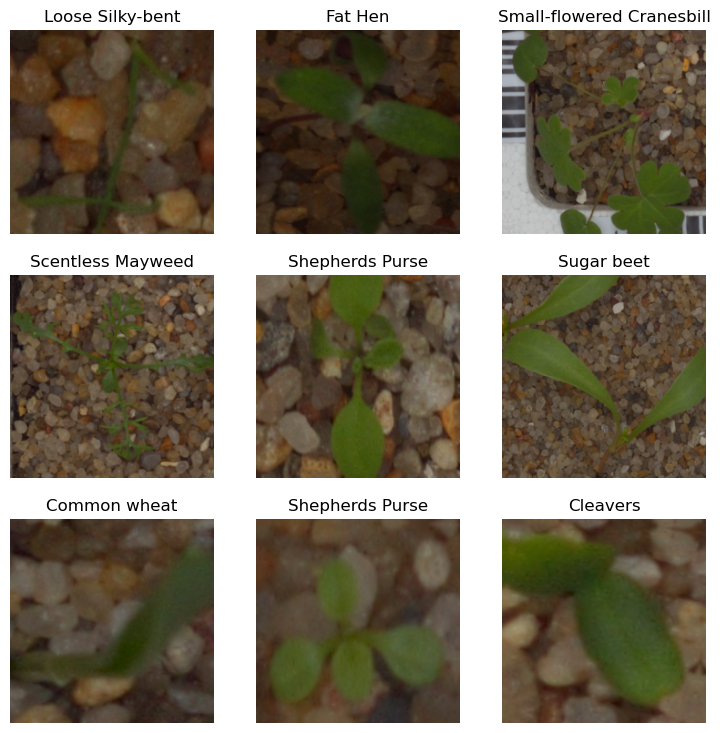

In [7]:
plant = DataBlock(blocks=(ImageBlock , CategoryBlock) ,
                   get_items=get_image_files,
                   get_y = parent_label,
                   item_tfms = RandomResizedCrop(460, min_scale=0.75),
                   batch_tfms = [*aug_transforms(size=224, max_warp=0, max_zoom= 0.8), Normalize.from_stats(*imagenet_stats)])

train_dls = plant.dataloaders(train_data, bs=64)
train_dls.show_batch()

In [8]:
print(train_dls.vocab)
len(train_dls.vocab)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


12

In [9]:
# Getting the Metrics for evaluation

f1_score = F1Score(average='micro')
precision = Precision(average='micro')
recall = Recall(average='micro')

In [10]:
learn = cnn_learner(train_dls, resnet50, pretrained=True, metrics=[error_rate ,f1_score, precision, recall ,accuracy]).to_fp16()

/raid10/active_users/groupA/miniconda/lib/python3.11/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/raid10/active_users/groupA/miniconda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid10/active_users/groupA/miniconda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

SuggestedLRs(valley=0.0008317637839354575)

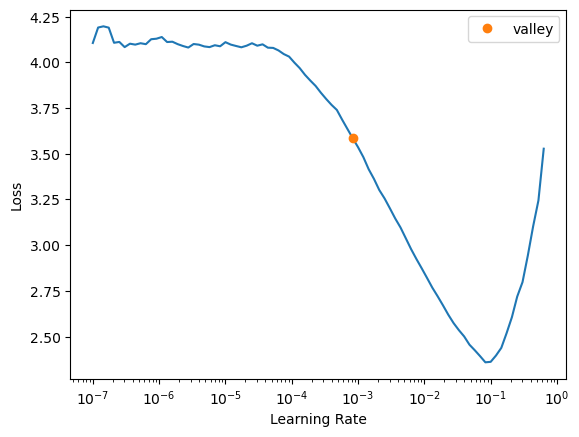

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(4, 0.0008317637839354575)

epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,accuracy,time
0,1.917874,0.599684,0.194737,0.805263,0.805263,0.805263,0.805263,00:13
1,0.923814,0.253055,0.081053,0.918947,0.918947,0.918947,0.918947,00:13
2,0.517450,0.205732,0.071579,0.928421,0.928421,0.928421,0.928421,00:12
3,0.365549,0.196749,0.061053,0.938947,0.938947,0.938947,0.938947,00:13


In [14]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [15]:
print("Accuracy: ", 1-float(learn.recorder.metrics[0].value))

Accuracy:  0.9389473684132099


In [16]:
learn.unfreeze()

SuggestedLRs(valley=3.0199516913853586e-05)

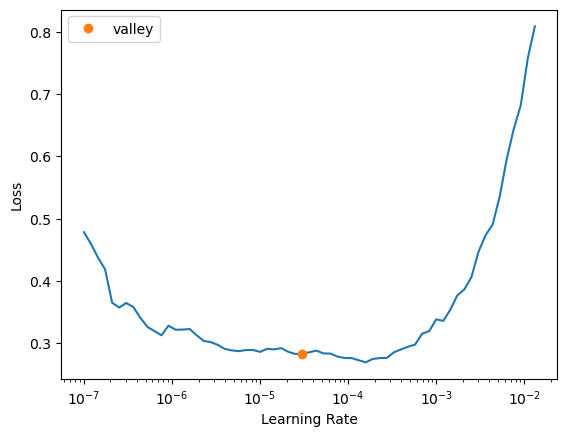

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(10, lr_max = 3.0199516913853586e-05)

epoch,train_loss,valid_loss,error_rate,f1_score,precision_score,recall_score,accuracy,time
0,0.291472,0.188054,0.057895,0.942105,0.942105,0.942105,0.942105,00:15
1,0.257222,0.174968,0.053684,0.946316,0.946316,0.946316,0.946316,00:15
2,0.212788,0.160692,0.048421,0.951579,0.951579,0.951579,0.951579,00:15
3,0.176849,0.147590,0.051579,0.948421,0.948421,0.948421,0.948421,00:15
4,0.135923,0.150050,0.051579,0.948421,0.948421,0.948421,0.948421,00:14
5,0.102702,0.129095,0.045263,0.954737,0.954737,0.954737,0.954737,00:15
6,0.089691,0.121884,0.041053,0.958947,0.958947,0.958947,0.958947,00:14
7,0.076571,0.141220,0.045263,0.954737,0.954737,0.954737,0.954737,00:14
8,0.064803,0.124619,0.040000,0.960000,0.960000,0.960000,0.960000,00:14
9,0.056177,0.123948,0.037895,0.962105,0.962105,0.962105,0.962105,00:15


In [19]:
learn.save('stage-2')

Path('models/stage-2.pth')

In [20]:
print("Accuracy: ", 1-float(learn.recorder.metrics[0].value))

Accuracy:  0.9621052630245686


In [21]:
interpretation = ClassificationInterpretation.from_learner(learn)

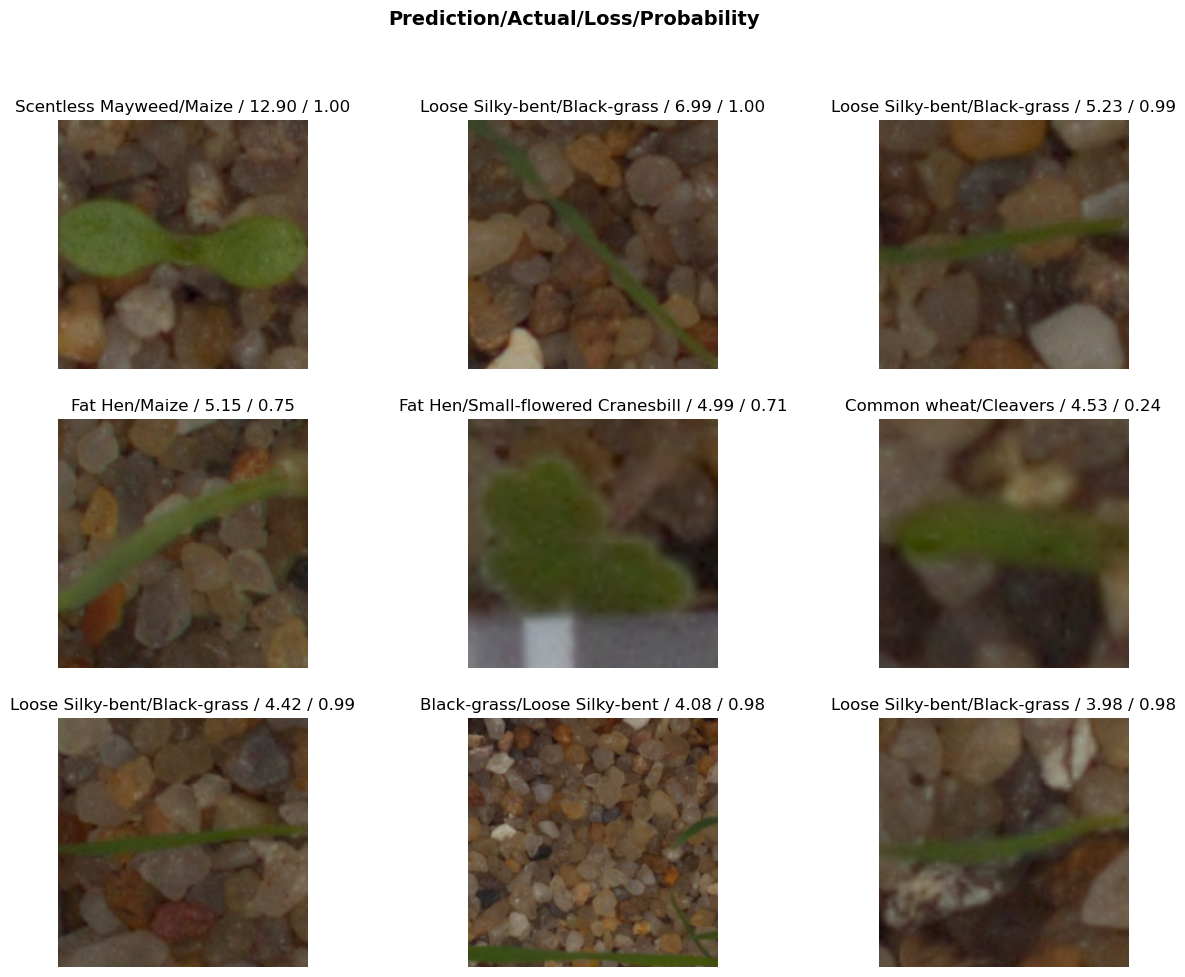

In [22]:
interpretation.plot_top_losses(9, figsize=(15,11))

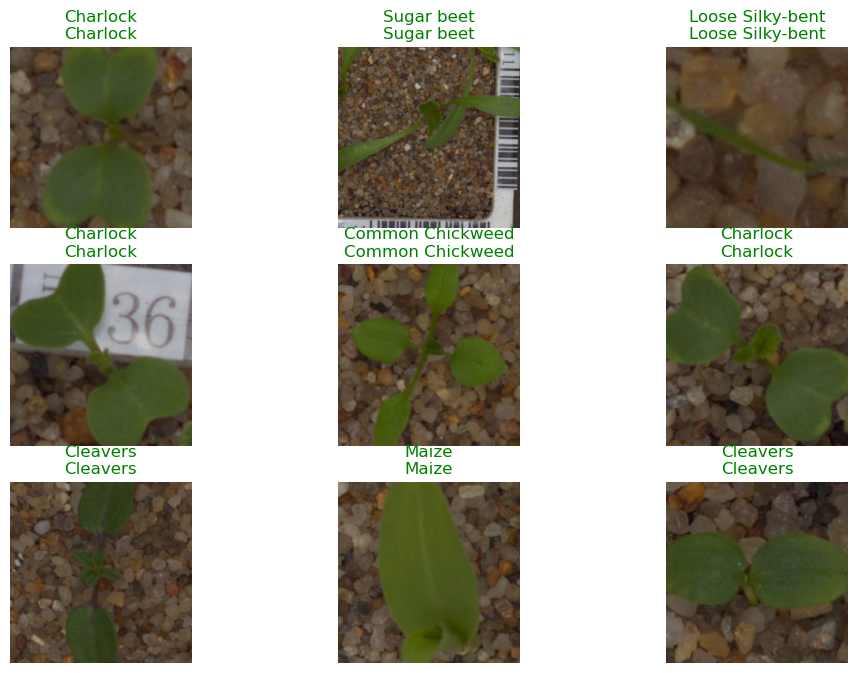

In [23]:
learn.show_results(figsize=(12,8))

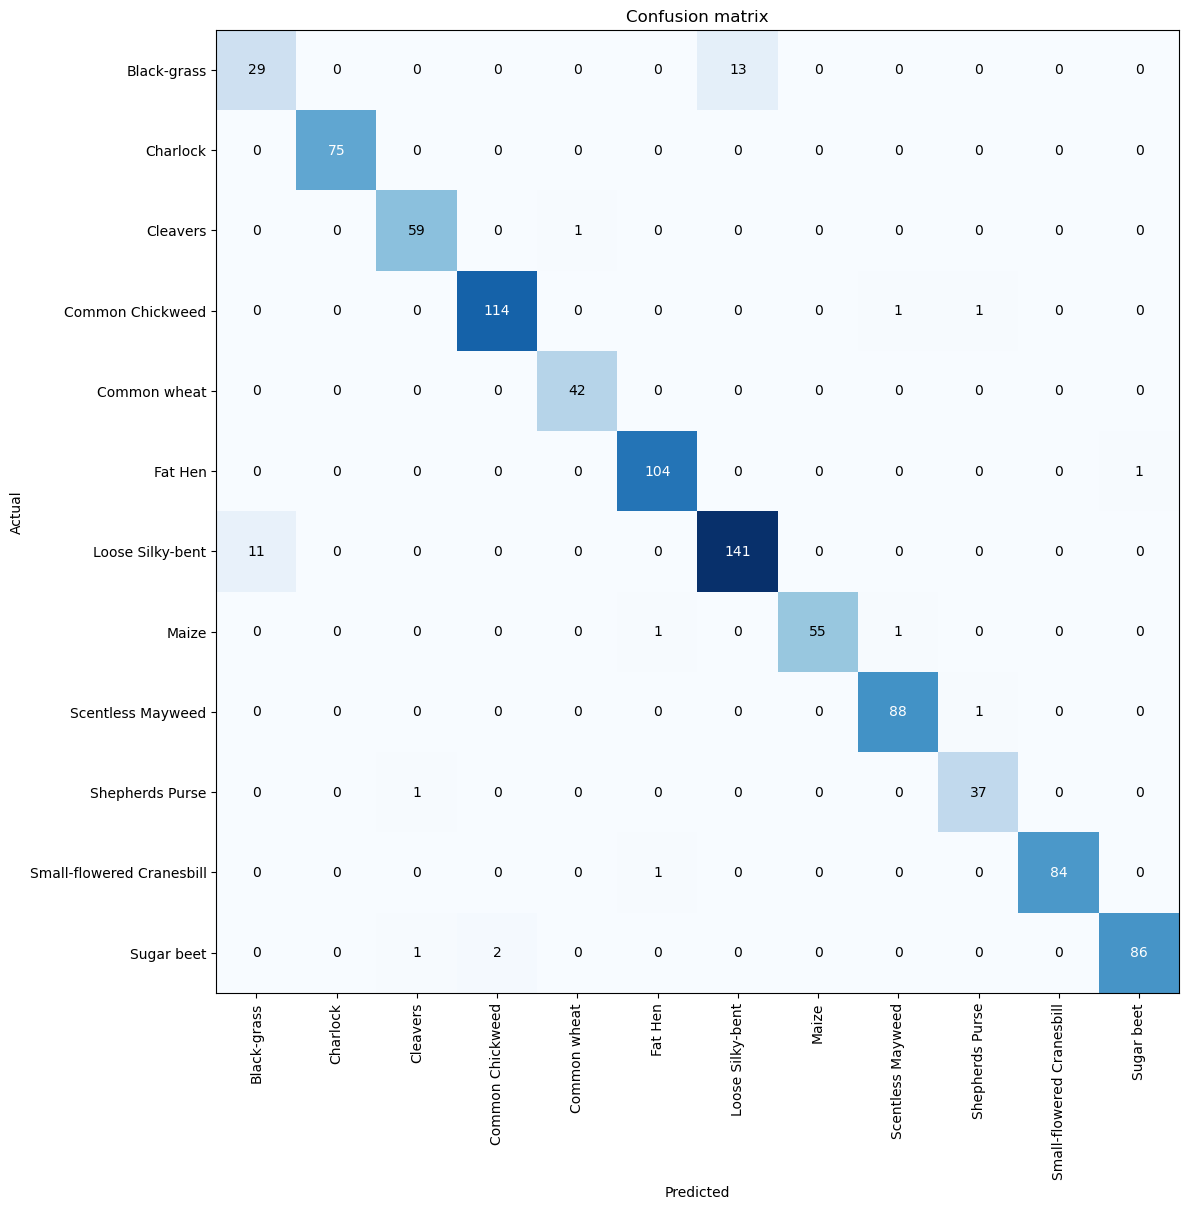

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(16,12))

In [25]:
# testing

In [37]:
test_loader = train_dls.test_dl(test_fns) 
test_pred, y = learn.get_preds(dl=test_loader)

In [38]:
test_pred

tensor([[4.0480e-08, 4.1306e-10, 5.8717e-09,  ..., 1.5832e-10, 5.3750e-09,
         1.3234e-07],
        [1.0568e-09, 1.0866e-06, 2.1220e-07,  ..., 8.6933e-10, 6.4856e-10,
         9.9998e-01],
        [2.6514e-05, 2.5300e-05, 6.3844e-06,  ..., 3.8396e-04, 9.9929e-01,
         2.4642e-05],
        ...,
        [5.2862e-06, 1.8849e-06, 6.6004e-07,  ..., 1.3149e-11, 1.2186e-10,
         2.6016e-06],
        [3.5539e-07, 9.9957e-01, 2.7471e-05,  ..., 4.6899e-07, 3.1133e-04,
         1.9210e-07],
        [1.4003e-02, 3.0215e-05, 2.3730e-04,  ..., 5.2055e-05, 6.2240e-05,
         2.8372e-04]])

In [39]:
pred_labels = torch.argmax(test_pred, dim=1)
pred_labels[1:10]

tensor([11, 10, 11,  6,  3, 11,  5, 11,  6])

In [41]:
vocab = {key: val for key, val in enumerate(train_dls.vocab)}
vocab

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

In [45]:
predicted_labels = []
for i in pred_labels:
    predicted_labels.append(vocab[i.float().item()])

In [47]:
predicted_labels[1:10]

['Sugar beet',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Loose Silky-bent',
 'Common Chickweed',
 'Sugar beet',
 'Fat Hen',
 'Sugar beet',
 'Loose Silky-bent']

In [65]:
test_files = []
for i in test_fns:
    print(i.name)
    test_files.append(i.name)

d7017f701.png
6680836dd.png
a0b393945.png
e783f5a4f.png
d93c7ab6d.png
df7cb5f87.png
24c94a6ca.png
444473900.png
9baf94467.png
3f92d8039.png
d84d37a61.png
4f44ca525.png
b7a7f6390.png
1d0cbd819.png
ec08a5d56.png
3da774107.png
8e6ec1ca6.png
8e4eaeec0.png
03ef36742.png
1f5e5554e.png
78750e0ff.png
e471f1d3a.png
809eb0b82.png
8916793ce.png
c06e7c748.png
1b490196c.png
b6a3f7876.png
04814f36d.png
0d31e6602.png
a8da9c08d.png
1c52ea820.png
55fed435f.png
cfd8165e9.png
17529c555.png
aaf4da98f.png
8b27bfd2b.png
2d5058a59.png
5bdcfa329.png
a006a475c.png
f4ad9d950.png
37c3108d6.png
0caeda5df.png
86f08e6d1.png
9d3cb4745.png
e73e308be.png
d2f0f326e.png
f9f35cbd4.png
c7b07431e.png
6dd095129.png
d17f48d3b.png
2f0004a7f.png
c26ccf73c.png
728eabae1.png
3e9f41817.png
00c47e980.png
2dd5cfba9.png
19b51843a.png
f48916a8c.png
13b9fa92d.png
b39c71707.png
b1cd2a91e.png
c2de6020a.png
efe19dc32.png
1c680883c.png
bb1d1bfd3.png
9fab816f2.png
1d56351b2.png
acdb75e00.png
f25996db8.png
0dba99002.png
ce3d280eb.png
ab3545

AttributeError: 'str' object has no attribute 'name'

In [66]:
test_files[1:5]

['6680836dd.png', 'a0b393945.png', 'e783f5a4f.png', 'd93c7ab6d.png']

In [67]:
csv_file =  pd.DataFrame({'file': test_files,'species': predicted_labels})
csv_file.to_csv('labels.csv',index=False)

In [29]:
# figure out how to see the accuracy

In [100]:
accuracy = accuracy(test_pred, y)
print(f'Accuracy: {accuracy:.4f}')

AttributeError: 'NoneType' object has no attribute 'contiguous'